In [1]:
from reader import readShortVideo
from reader import getVideoList
import matplotlib.pyplot as plt
from os import listdir
import os
import pandas as pd
import numpy as np
import pickle

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# load data
class CustomDataset(Dataset):
    def __init__(self, train_valid="train"):
        if train_valid == "train":
            with open("../features/train_X_d6.pkl", "rb") as f:
                self.X = pickle.load(f)
            with open("../features/train_y.pkl", "rb") as f:
                self.y = pickle.load(f)
                
        if train_valid == "valid":
            with open("../features/valid_X_d6.pkl", "rb") as f:
                self.X = pickle.load(f)
            with open("../features/valid_y.pkl", "rb") as f:
                self.y = pickle.load(f)
    def __getitem__(self, index):
        single_image = self.X[index]
        single_label = self.y[index]

        # Return image and the label
        return single_image, single_label

    def __len__(self):
        return self.length

train_dataset = CustomDataset("train")
valid_dataset = CustomDataset("valid")

In [3]:
len(train_dataset.X)

3236

In [4]:
cnn_feature_extractor = torchvision.models.densenet121(pretrained=True).features.cuda() # to 1000 dims
# cnn_feature_extractor = nn.Sequential(*list(pre_trained_model.children()))

/home/thtang/.local/lib/python3.5/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [5]:
cnn_feature_extractor

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), st

In [6]:
with torch.no_grad():
    output_size = cnn_feature_extractor(train_dataset[0][0].cuda()).size()
print(output_size)

torch.Size([9, 1024, 7, 7])


In [7]:
feature_size = 1024*7*7
cnn_feature_extractor.eval()
train_features = []
counter = 0
with torch.no_grad():
    for i in range(len(train_dataset.X)):
        input_X = train_dataset[i][0]
        feature = cnn_feature_extractor(input_X.cuda()).cpu().view(-1, feature_size)
        train_features.append(torch.mean(feature,0))
        counter +=1
        if counter % 300 == 0:
            print(counter)
print("training instances done")

valid_features = []
counter = 0
with torch.no_grad():
    for i in range(len(valid_dataset.X)):
        input_X = valid_dataset[i][0]
        feature = cnn_feature_extractor(input_X.cuda()).cpu().view(-1, feature_size)
        valid_features.append(torch.mean(feature,0))
        counter +=1
        if counter % 100 == 0:
            print(counter)

300
600
900
1200
1500
1800
2100
2400
2700
3000
training instances done
100
200
300
400
500


In [8]:
train_X = torch.stack(train_features)
train_y = torch.LongTensor(train_dataset.y)

valid_X = torch.stack(valid_features)
valid_y = torch.LongTensor(valid_dataset.y)

In [9]:
train_X.size()

torch.Size([3236, 50176])

In [10]:
class Net(torch.nn.Module):
    def __init__(self, feature_size):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(feature_size,4096)
        self.linear2 = nn.Linear(4096,1024)
        self.linear3 = nn.Linear(1024, 11)
        self.softmax = nn.Softmax(1)
        self.relu = nn.ReLU()
        self.bn_1 = nn.BatchNorm1d(4096)
        self.bn_2 = nn.BatchNorm1d(1024)
    def forward(self, x):
        x = self.relu(self.bn_1(self.linear1(x))) # same as relu output
        x = self.relu(self.bn_2(self.linear2(x)))
        y_pred = self.softmax(self.linear3(x))
        return y_pred

In [12]:
train_loss = []
validation_acc = []
model = Net(feature_size).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
BATCH_SIZE = 64
loss_function = nn.CrossEntropyLoss()
max_accuracy = 0
model.train()
for epoch in range(30):
    print("Epoch:", epoch+1)
    CE_loss = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = train_X[perm_index]
    train_y_sfl = train_y[perm_index]
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        optimizer.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]
        input_y = train_y_sfl[index:index+BATCH_SIZE]
        # use GPU
        input_X = input_X.cuda()
        # forward + backward + optimize
        output = model(input_X)
        loss = loss_function(output, input_y.cuda())
        loss.backward()
        optimizer.step()
        CE_loss += loss.cpu().data.numpy()
    print("training loss",CE_loss)
    train_loss.append(CE_loss)
    # validation 
    with torch.no_grad():
        model.eval()
        output = model(valid_X.cuda())
        output_label = torch.argmax(output,1).cpu().data
        accuracy = np.mean((output_label == valid_y).numpy())
        print("validation accuracy: ",accuracy)
        validation_acc.append(accuracy)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        torch.save(model.state_dict(), "../models/CNN_FC_model.pkt")
    model.train()

Epoch: 1
training loss 109.66244268417358
validation accuracy:  0.4332688588007737
Epoch: 2
training loss 101.88214063644409
validation accuracy:  0.4700193423597679
Epoch: 3
training loss 96.4647958278656
validation accuracy:  0.48936170212765956
Epoch: 4
training loss 92.33171713352203
validation accuracy:  0.4448742746615087
Epoch: 5
training loss 89.27583682537079
validation accuracy:  0.4564796905222437
Epoch: 6
training loss 86.96552014350891
validation accuracy:  0.46421663442940037
Epoch: 7
training loss 85.28621995449066
validation accuracy:  0.47775628626692457
Epoch: 8
training loss 83.93100774288177
validation accuracy:  0.45454545454545453
Epoch: 9
training loss 83.08584070205688
validation accuracy:  0.4738878143133462
Epoch: 10
training loss 82.15546596050262
validation accuracy:  0.4506769825918762
Epoch: 11
training loss 81.3363893032074
validation accuracy:  0.41005802707930367
Epoch: 12
training loss 81.01451897621155
validation accuracy:  0.4526112185686654
Epoch: 1

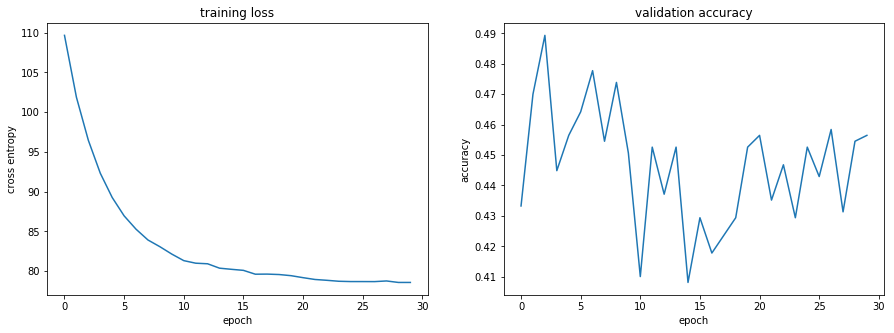

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss)
plt.title("training loss")
plt.ylabel("cross entropy")
plt.xlabel("epoch")
plt.subplot(1,2,2)
plt.plot(validation_acc)
plt.title("validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.savefig("p1_curve.png")
plt.show()